<a href="https://colab.research.google.com/github/mrSaggio/mrSaggio/blob/main/yolov5_tutorial_train_with_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

This notebook show how to train YOLOv5 object detector using custom data. For this purpose I created [Dataset](https://www.kaggle.com/datasets/maxkav/yolov5-game-dataset-for-darknet-framework?sort=recent-comments&select=notes.json) of images and labels.

Steps of all the process:
1. Collect lots of images.
2. Label images using labeling tool.
3. Train model and get weights file.
4. Initialize model with weights file & use it.

# Initialize constants

Set BASE_MODEL according to [Pretrained Checkpoints](https://github.com/ultralytics/yolov5/releases)

In [1]:
PROJECT_NAME = "yolov5_train"
BASE_MODEL = "yolov5m6.pt"
TRAIN_BATCH = 32
TRAIN_EPOCHS = 200
VAL_BATCH = 64

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Clone yolov5 repo

In [3]:
! git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16512, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 16512 (delta 41), reused 49 (delta 15), pack-reused 16408
Receiving objects: 100% (16512/16512), 15.12 MiB | 22.50 MiB/s, done.
Resolving deltas: 100% (11306/11306), done.


In [4]:
! pip install -qr yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.5/719.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


# Import libraries

This notebook contains steps to train and evaluate yolov5 model with custom data from scratch.

Steps to reproduce:
1. Collect lots of images.
2. Label images using labeling tool.
4. Train model and get weights file.
5. Initialize model with weights file & use it.

In [5]:
import torch
from yolov5 import utils
import torch
from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import io
import os
import cv2
import json
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

# Convert data to yolov5 Pytorch format

Prepare data from Label Studio yolov5 darknet format to pytorch yolov5

In [11]:
IMAGES_PATH = "/content/drive/MyDrive/truba/images"
LABELS_PATH = "/content/drive/MyDrive/truba/labels"
NOTES_PATH = "/content/drive/MyDrive/truba/notes.json"

In [12]:
# Read labels
labels = os.listdir(LABELS_PATH)

# Split data
train, test = train_test_split(labels, test_size=0.15, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

train: 12; valid: 2; test: 1


Make dirs for pytorch dataset format

In [14]:
os.makedirs("test/images")
os.makedirs("test/labels")
os.makedirs("train/images")
os.makedirs("train/labels")
os.makedirs("valid/images")
os.makedirs("valid/labels")

In [15]:
def move_files_to_dir(files, dirname):
    for label_filename in files:
        image_filename = f"{label_filename[:-4]}.jpg"
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{dirname}/images/{image_filename}")
        shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{dirname}/labels/{label_filename}")

# Move splits to folders
move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")

Convert yolov5-darknet to yolov5-pytorch description file

In [16]:
descr_darknet = json.load(open(NOTES_PATH))

train_path = "../train/images"
test_path = "../test/images"
valid_path = "../valid/images"

nc = len(descr_darknet["categories"])
names = [category["name"] for category in descr_darknet["categories"]]

print(
    f"train: {train_path}\n"
    f"test: {test_path}\n"
    f"val: {valid_path}\n\n"
    f"nc: {nc}\n"
    f"names: {names}",
)

train: ../train/images
test: ../test/images
val: ../valid/images

nc: 20
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'В', 'Г', 'З', 'К', 'О', 'П', 'С', 'Т', 'У']


In [17]:
with open("data.yaml", "w") as file:
    yaml.dump({
        "train": train_path,
        "test": test_path,
        "val": valid_path,
        "nc": nc,
        "names": [f'{name}' for name in names]
    }, stream=file, default_flow_style=None)

In [18]:
print("Now we are ready to train yolov5 model")
! ls

Now we are ready to train yolov5 model
data.yaml  drive  sample_data  test  train  valid  yolov5  yolov5m6.pt


# Train yolov5

In [19]:
# Delete old results if exists
wildcard = f"{PROJECT_NAME}/feature_extraction*"
! rm -r $wildcard

rm: cannot remove 'yolov5_train/feature_extraction*': No such file or directory


In [20]:
! python yolov5/train.py --batch $TRAIN_BATCH --epochs $TRAIN_EPOCHS --data "data.yaml" --weights $BASE_MODEL --project $PROJECT_NAME --name 'feature_extraction' --cache --freeze 12

2024-03-07 07:27:16.019167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 07:27:16.019251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 07:27:16.020917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m6.pt, cfg=, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_c

In [24]:
!zip -r /content/yolov5_train.zip /content/yolov5_train

  adding: content/yolov5_train/ (stored 0%)
  adding: content/yolov5_train/feature_extraction/ (stored 0%)
  adding: content/yolov5_train/feature_extraction/weights/ (stored 0%)
  adding: content/yolov5_train/feature_extraction/weights/best.pt (deflated 8%)
  adding: content/yolov5_train/feature_extraction/weights/last.pt (deflated 8%)
  adding: content/yolov5_train/feature_extraction/R_curve.png (deflated 13%)
  adding: content/yolov5_train/feature_extraction/PR_curve.png (deflated 12%)
  adding: content/yolov5_train/feature_extraction/confusion_matrix.png (deflated 26%)
  adding: content/yolov5_train/feature_extraction/results.png (deflated 6%)
  adding: content/yolov5_train/feature_extraction/events.out.tfevents.1709796438.b031a8e4c260.6646.0 (deflated 41%)
  adding: content/yolov5_train/feature_extraction/F1_curve.png (deflated 13%)
  adding: content/yolov5_train/feature_extraction/train_batch1.jpg (deflated 18%)
  adding: content/yolov5_train/feature_extraction/val_batch0_pred.jpg

# Validation

In [25]:
# Delete old results
wildcard = f"{PROJECT_NAME}/validation_on_test_data*"
! rm -r $wildcard

rm: cannot remove 'yolov5_train/validation_on_test_data*': No such file or directory


In [26]:
WEIGHTS_BEST = f"{PROJECT_NAME}/feature_extraction/weights/best.pt"
! python yolov5/val.py --weights $WEIGHTS_BEST --batch $VAL_BATCH --data 'data.yaml' --task test --project $PROJECT_NAME --name 'validation_on_test_data' --augment

val: data=data.yaml, weights=['yolov5_train/feature_extraction/weights/best.pt'], batch_size=64, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5_train, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-290-gb2ffe055 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
Model summary: 276 layers, 35358588 parameters, 0 gradients, 49.1 GFLOPs
test: Scanning /content/test/labels... 1 images, 0 backgrounds, 0 corrupt: 100% 1/1 [00:00<00:00, 30.96it/s]
test: New cache created: /content/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.17s/it]
                   all          1         10      0.956      0.157      0.285      0.124
                     0          1          3      0.735      0.941      0.913 

# Test detection

In [27]:
# Delete old results
wildcard = f"{PROJECT_NAME}/detect_test*"
! rm -r $wildcard

rm: cannot remove 'yolov5_train/detect_test*': No such file or directory


In [28]:
! python yolov5/detect.py --weights $WEIGHTS_BEST --conf 0.6 --source 'test/images' --project $PROJECT_NAME --name 'detect_test' --augment --line=3

detect: weights=['yolov5_train/feature_extraction/weights/best.pt'], source=test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=yolov5_train, name=detect_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-290-gb2ffe055 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
Model summary: 276 layers, 35358588 parameters, 0 gradients, 49.1 GFLOPs
image 1/1 /content/test/images/b22a9aed-2.jpg: 128x640 (no detections), 1012.9ms
Speed: 0.7ms pre-process, 1012.9ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5_train/detect_test


In [29]:
def read_images(dirpath):
  images = []
  for img_filename in os.listdir(dirpath):
    images.append(mpimg.imread(f"{dirpath}/{img_filename}"))
  return images

In [30]:
def label_test_images(test_images_path, test_labels_path, classes):
  test_images = os.listdir(test_images_path)
  labeled_images = []

  for idx, test_image_filename in enumerate(test_images):
    image = mpimg.imread(f"{test_images_path}/{test_image_filename}")

    x_shape, y_shape = image.shape[1], image.shape[0]

    test_label_filename = f"{test_image_filename[:-4]}.txt"

    with open(f"{test_labels_path}/{test_label_filename}", "r") as f:
      lines = f.readlines()

      for line in lines:
        # Parse line
        box = line.split()
        class_idx = box[0]

        class_name = names[int(class_idx)]
        x_center, y_center, box_w, box_h = int(float(box[1])*x_shape), int(float(box[2])*y_shape), int(float(box[3])*x_shape), int(float(box[3])*y_shape)
        x1, y1, x2, y2 = x_center-int(box_w/2), y_center-int(box_h/2), x_center+int(box_w/2), y_center+int(box_h/2)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
        cv2.putText(image, class_name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 3)

    labeled_images.append(image)

  return labeled_images

In [31]:
detect_path = f"{PROJECT_NAME}/detect_test"
test_images_path = f"test/images"
test_labels_path = f"test/labels"

detected_images = read_images(detect_path)
test_labeled_images = label_test_images(test_images_path, test_labels_path, classes=names)

stacked_images = [np.hstack([detected_images[idx], test_labeled_images[idx]]) for idx in range(len(detected_images))]

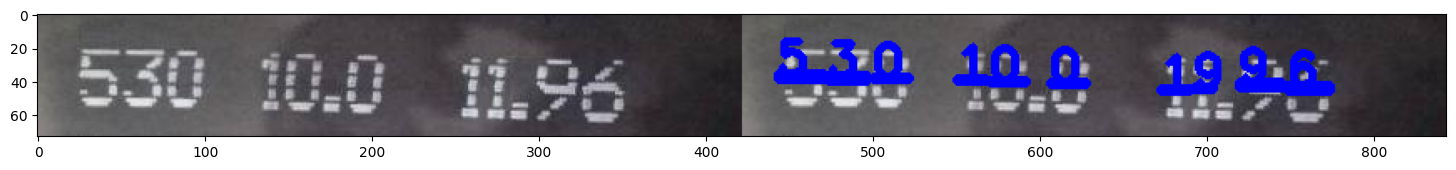

In [33]:
for image in stacked_images:
  fig = plt.figure(figsize=(40, 15))
  ax1 = fig.add_subplot(2,2,1)
  ax1.imshow(image)

# Save model

To save your model just download best.pt file from PROJECT_FOLDER -> feature_extraction (your best) -> weights -> best.pt

File best.pt will be used to load it in your project to predict.